## Тест модуля восстановления глубины

#### Импортирование общих библиотек и OPR

In [1]:
import sys
sys.path.append('/home/kirill/TopoSLAM/OpenPlaceRecognition/src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread
from skimage.transform import resize
from scipy.spatial.transform import Rotation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from opr.pipelines.depth_estimation import DepthEstimation

#### Задание нейросети восстановления глубины

In [5]:
sys.path.append('/home/kirill/AdelaiDepth/LeReS/Minist_Test')
from lib.multi_depth_model_woauxi import RelDepthModel
from lib.net_tools import load_ckpt

In [6]:
def parse_args(a):
    parser = argparse.ArgumentParser(
        description='Configs for LeReS')
    parser.add_argument('--load_ckpt', default='./res50.pth', help='Checkpoint path to load')
    parser.add_argument('--backbone', default='resnext101', help='Checkpoint path to load')

    args = parser.parse_args(a)
    return args

In [7]:
import argparse
arguments = "--load_ckpt /home/kirill/AdelaiDepth/weights/res50.pth \
            --backbone resnet50".split()
args = parse_args(arguments)

In [8]:
rel_depth_model = RelDepthModel(backbone='resnet50')
load_ckpt(args, rel_depth_model, None, None)

loading checkpoint /home/kirill/AdelaiDepth/weights/res50.pth


#### Задание трансформации между лидаром и камерой (данные из росбэга с робота Husky)

In [9]:
camera_matrix = {'f': 683.6, 'cx': 615.1, 'cy': 345.3}
rotation = [-0.498, 0.498, -0.495, 0.510]
R = Rotation.from_quat(rotation).as_matrix()
R = np.linalg.inv(R)
translation = np.array([[0.061], [0.049], [-0.131]])
tf_matrix = np.concatenate([R, translation], axis=1)
tf_matrix = np.concatenate([tf_matrix, np.array([[0, 0, 0, 1]])], axis=0)

In [10]:
tf_matrix.T

array([[ 0.01505794,  0.00888194,  0.99984717,  0.        ],
       [-0.99977525,  0.01505794,  0.01492309,  0.        ],
       [-0.01492309, -0.99984717,  0.00910668,  0.        ],
       [ 0.061     ,  0.049     , -0.131     ,  1.        ]])

#### Инициализация модуля восстановления глубины

In [11]:
de = DepthEstimation(camera_matrix=camera_matrix,
                     lidar_to_camera_transform=tf_matrix.T,
                     model=rel_depth_model)#,
                     #model_weights_path='/home/kirill/AdelaiDepth/weights/res50.pth')

#### Взятие тестового изображения и лидарного облака из датасета ITLP-Campus (сменить пути на актуальные)

In [12]:
#ts = 1698265170740415257640960
ts = 1698265251815700618543104
test_img_file = '/home/kirill/TopoSLAM/OpenPlaceRecognition/data/floor5_processed/front_cam/{}.png'.format(ts)
#ts_lidar = 1698265170777994342432768
ts_lidar = 1698265251843991031250944
test_cloud_file = '/home/kirill/TopoSLAM/OpenPlaceRecognition/data/floor5_processed/lidar/{}.bin'.format(ts_lidar)

In [13]:
test_img = imread(test_img_file)
#test_img = resize(test_img, (480, 640))
test_cloud = np.fromfile(test_cloud_file, sep=',').reshape((-1, 4))[:, :3]

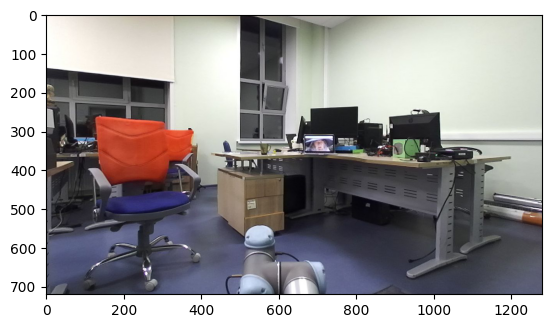

In [14]:
plt.imshow(test_img)

#### Запуск восстановления глубины

In [15]:
depth = de.get_depth_with_lidar(test_img, test_cloud[:, :3])

(26948, 4)
1.3244709228900056 0.573949915611921 6.5691945563798155


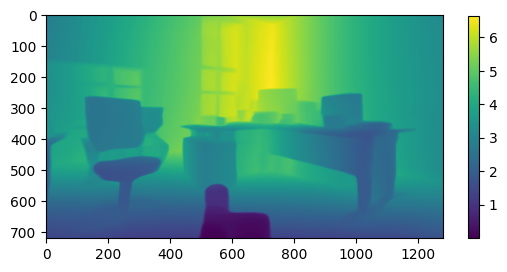

In [16]:
plt.imshow(depth)
plt.colorbar(shrink=0.6)

#### Создание облака точек по восстановленной глубине методом обратной проекции

In [17]:
h, w = depth.shape
def get_point_cloud_from_depth(depth, f, cx, cy):
    print(depth.shape, f, cx, cy)
    i = np.tile(np.arange(h), w).reshape((w, h)).T
    j = np.tile(np.arange(w), h).reshape((h, w))
    z = depth.ravel()
    x = (j.ravel() - cx) / f * z
    y = (i.ravel() - cy) / f * z
    pcd = np.zeros((x.shape[0], 3))
    pcd[:, 0] = x
    pcd[:, 1] = y
    pcd[:, 2] = z
    return pcd

pcd = get_point_cloud_from_depth(depth, camera_matrix['f'], camera_matrix['cx'], camera_matrix['cy'])

(720, 1280) 683.6 615.1 345.3


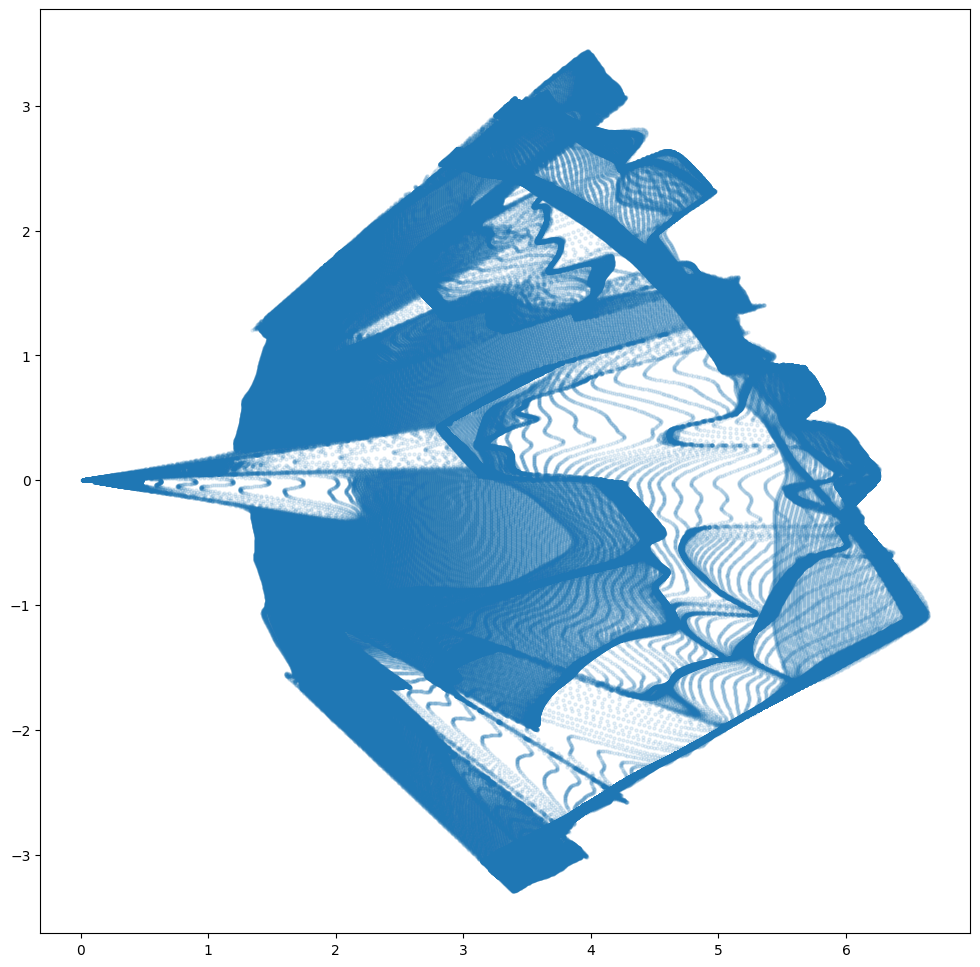

In [18]:
plt.figure(figsize=(12, 12))
plt.scatter(pcd[:, 2], -pcd[:, 0], s=5, alpha=0.1)

#### Сравнение восстановленного и лидарного облака

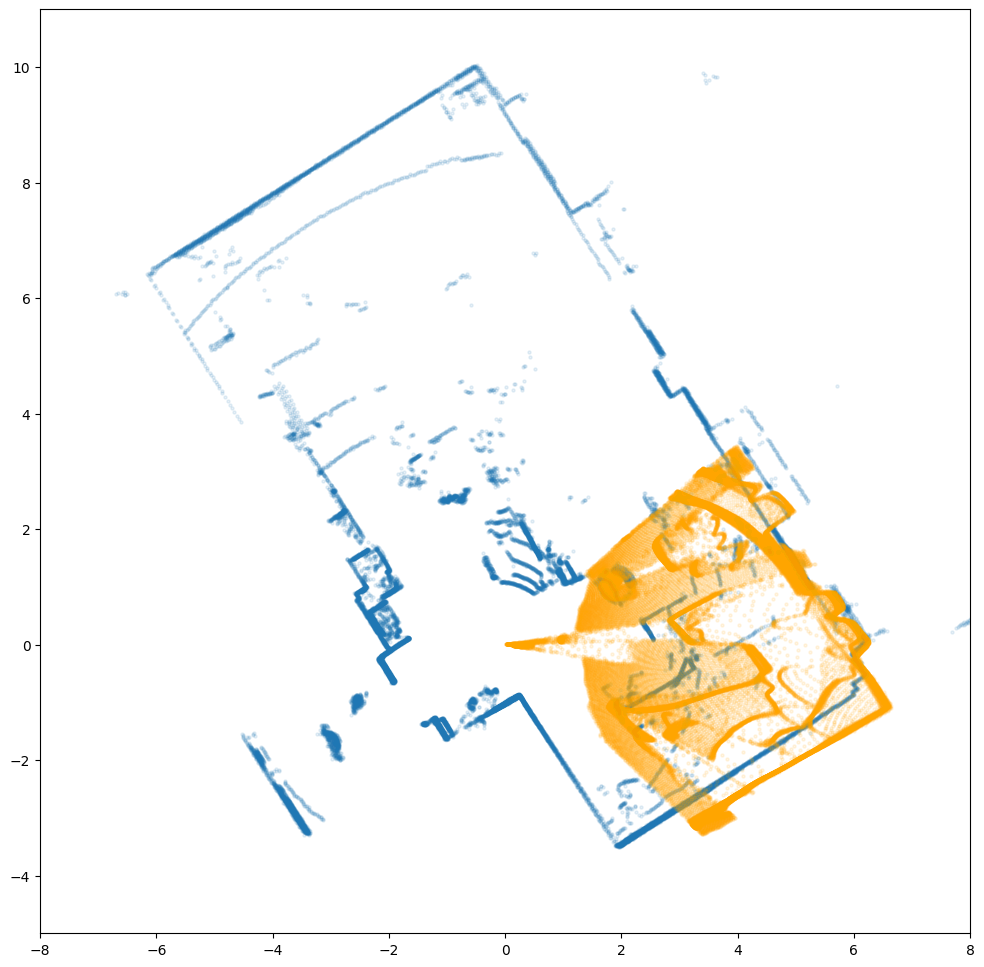

In [19]:
plt.figure(figsize=(12, 12))
plt.xlim((-8, 8))
plt.ylim((-5, 11))
plt.scatter(test_cloud[:, 0], test_cloud[:, 1], s=5, alpha=0.1)
plt.scatter(pcd[::17, 2], -pcd[::17, 0], color='orange', s=5, alpha=0.1)
plt.savefig('pointcloud_from_nn_depth.png')